# 1 Пункт

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LinearRegression
from scipy.special import erfinv, erf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [20]:
random.seed(13)
np.random.seed(13)

In [21]:
data = pd.read_csv('/home/owid-covid-data.csv')
data.shape

(261268, 67)

In [22]:
data[data['location'] == 'Russia']

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
192649,RUS,Europe,Russia,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,-5538.0,-3.33,-3.33,-38.03119
192650,RUS,Europe,Russia,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
192651,RUS,Europe,Russia,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
192652,RUS,Europe,Russia,2020-02-03,2.0,0.0,NaN,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
192653,RUS,Europe,Russia,2020-02-04,2.0,0.0,NaN,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193771,RUS,Europe,Russia,2023-02-26,21941582.0,9520.0,12265.000,388063.0,30.0,33.000,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
193772,RUS,Europe,Russia,2023-02-27,21951059.0,9477.0,11909.000,388091.0,28.0,32.857,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
193773,RUS,Europe,Russia,2023-02-28,21960719.0,9660.0,11693.000,388126.0,35.0,32.429,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
193774,RUS,Europe,Russia,2023-03-01,21974098.0,13379.0,11617.286,388163.0,37.0,33.000,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN


In [23]:
data = data[(data['date'] >= "2020-03-03") & (data['location'] == 'Russia' )]
data.shape

(1095, 67)

In [24]:
data = data.set_index(pd.Index(range(len(data))))

# 2 Пункт

<Axes: >

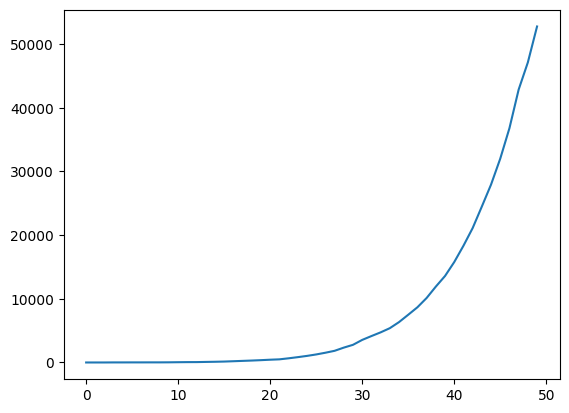

In [25]:
data['total_cases'][0:50].plot()

<Axes: >

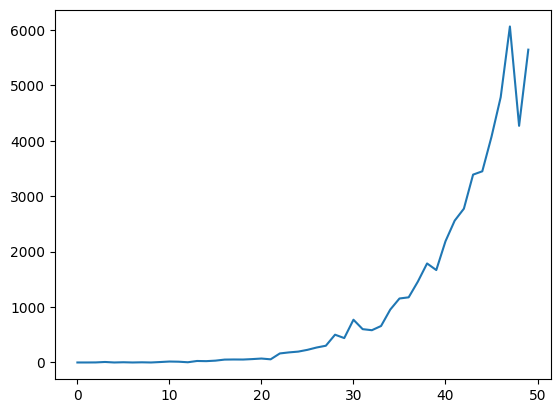

In [26]:
data['new_cases'][0:50].plot()

In [27]:
y = np.array(data['total_cases'][:50])
X = np.arange(50).reshape(-1, 1)
y_ln = np.log(y)
y_test = np.array(data['total_cases'][50 : ])
X_test = np.arange(50, len(y_test) + 50).reshape(-1, 1)
y_test_ln = np.log(y_test)
assert(len(X) + len(X_test) == len(data) and len(y) + len(y_test) == len(data))

In [28]:
model = LinearRegression().fit(X, y_ln)

In [29]:
def MSE(a, b):
    return (a - b) @ (a - b) / len(a)
print(f"MSELoss train - {MSE(model.predict(X), y_ln)}\n")
print(f"MSELoss test - {MSE(model.predict(X_test), y_test_ln)}")

MSELoss train - 0.12183046154391232

MSELoss test - 13369.47607591342


In [30]:
D_noise = np.sum((y_ln - model.predict(np.arange(50).reshape(-1, 1)))**2) / len(y_ln)
D_noise

0.12183046154391232

In [31]:
D_inv_aprior = np.eye(2,2)/1e4
D_inv_aprior

array([[0.0001, 0.    ],
       [0.    , 0.0001]])

In [32]:
x = np.concatenate((X, np.ones(len(X))[:,None]), axis = 1)
D = np.linalg.inv(D_inv_aprior + 1 / D_noise * x.T @ x)
E = D @ (1 / D_noise  * x.T @ y_ln)
print("E =", E)
print("D =", D)

E = [0.19829096 1.82073543]
D = [[ 1.17003962e-05 -2.86659638e-04]
 [-2.86659638e-04  9.45976806e-03]]


In [33]:
xs = np.arange(0, 200)
points = np.concatenate((np.arange(50)[:,None], y_ln[:,None]), axis = 1)
models = np.random.multivariate_normal(E, D, 100)

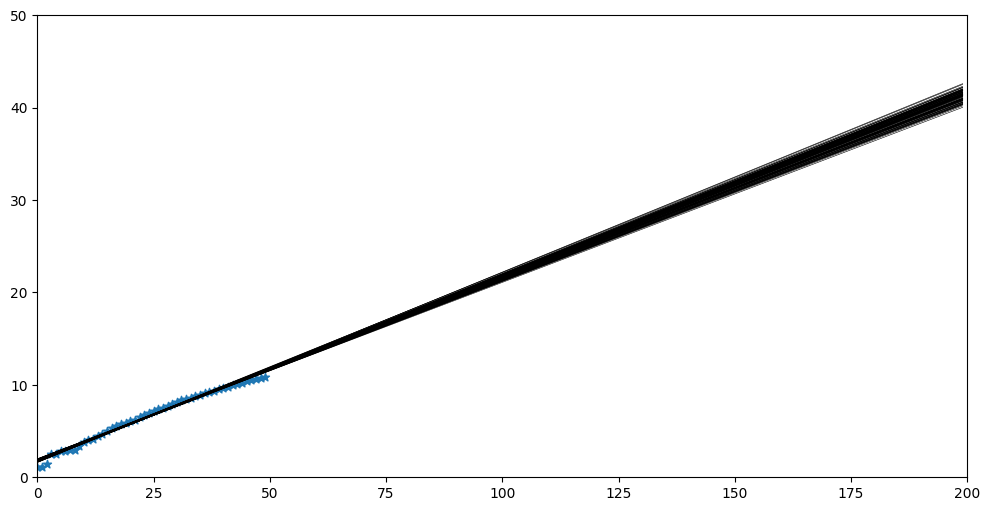

In [34]:
plt.figure(figsize=(12,6))
for w in models:
    plt.plot(xs, w[0] * xs + w[1], 'k-', lw=.4)
plt.ylim((0, 50))
plt.xlim((0, 200))
plt.scatter(points[:,0], points[:,1], marker='*')

In [35]:
data[(data['date']=='2020-05-01') | (data['date']=='2020-06-01') | (data['date']=='2020-09-01')]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
59,RUS,Europe,Russia,2020-05-01,114431.0,7933.0,6544.143,1169.0,96.0,79.143,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
90,RUS,Europe,Russia,2020-06-01,414328.0,8485.0,8700.143,4849.0,156.0,173.714,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
182,RUS,Europe,Russia,2020-09-01,997072.0,4670.0,4773.857,17250.0,122.0,103.714,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN


In [36]:
X_pred_test = np.array([60, 91, 183])
res = []
for i in [59, 90, 182]:
    pred = np.sum(i * models[:,0] + models[:,1]) / len(models)
    pred = np.exp(pred)
    res.append((pred, data.loc[i]['total_cases'], abs(data.loc[i]['total_cases'] - pred)))    

In [37]:
for i, j in enumerate(["May 1", "June 1", "September 1"]):
    print(f"{res[i][0]} cases of coronavirus infection expected by {j}. True value - {res[i][1]}. Difference - {res[i][2]}\n")

746138.953825934 cases of coronavirus infection expected by May 1. True value - 114431.0. Difference - 631707.953825934

350360970.54869753 cases of coronavirus infection expected by June 1. True value - 414328.0. Difference - 349946642.54869753

2.9745412715993956e+16 cases of coronavirus infection expected by September 1. True value - 997072.0. Difference - 2.9745412714996884e+16



# 3 Пункт

In [38]:
train_len = int(len(data['total_cases']) * 0.8)
test_len = len(data['total_cases']) - train_len
print("train len =", train_len)
print("test len =", test_len)

train len = 876
test len = 219


In [39]:
X_train = np.random.choice(len(data['total_cases']), train_len, replace=False)
X_test = np.array(list(set(range(len(data['total_cases']))) - set(X_train)))
y_train = np.array(data.loc[X_train]['total_cases'])
y_test = np.array(data.loc[X_test]['total_cases'])
assert(len(X_train) + len(X_test) == len(data))

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

In [40]:
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1))[ :, 0]
y_test = scaler.transform(y_test.reshape(-1, 1))[ :, 0]

In [41]:
eps = 1e-12
for i in y_train, y_test:
    i[i == 0] = i[i == 0] + eps
    i[i == 1] = i[i == 1] - eps

In [42]:
y_train = erfinv(2 * y_train - 1)
y_test = erfinv(2 * y_test - 1)

In [43]:
model = LinearRegression().fit(X_train, y_train)
preds = model.predict(X_test)
print(f"MSE test= {MSE(preds, y_test)}\nr2_score test= {r2_score(preds, y_test)}")

MSE test= 0.06662463687721308
r2_score test= 0.937109028536403


In [44]:
D_noise = np.sum((y_train - model.predict(X_train))**2) / len(y_train)
D_noise

0.09786571175153812

In [45]:
x = np.concatenate((X_train, np.ones(len(X_train))[:,None]), axis = 1)
D = np.linalg.inv(D_inv_aprior + 1 / D_noise * x.T @ x)
E = D @ (1 / D_noise  * x.T @ y_train)
print("E =", E)
print("D =", D)

E = [ 0.00329737 -2.02179103]
D = [[ 1.11145003e-09 -6.05556289e-07]
 [-6.05556289e-07  4.41646787e-04]]


In [46]:
xs = np.arange(0, 5000)
points = np.concatenate((X_train, y_train[:,None]), axis = 1)

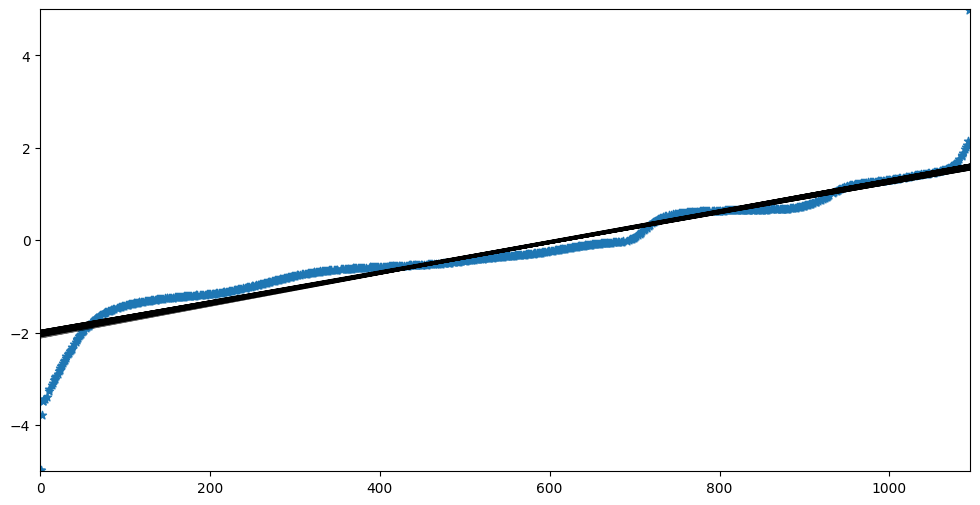

In [47]:
models = np.random.multivariate_normal(E, D, 5000)
plt.figure(figsize=(12, 6))
for w in models:
    plt.plot(xs, w[0] * xs + w[1], 'k-', lw=.4)
plt.ylim((-5, 5))
plt.xlim((0, 1095))
plt.scatter(points[:, 0], points[:, 1], marker='*')

In [48]:
x = np.arange(0, 5000).reshape(-1, 1)
x = np.concatenate((x, np.ones(len(x))[:,None]), axis = 1)

In [49]:
preds = np.sum((x @ models.T), axis = 1) / len(x)
preds = (erf(preds) + 1) / 2
preds = scaler.inverse_transform(preds.reshape(-1, 1))[ : , 0]
new_caces = np.array(sorted([preds[i + 1] - preds[i] for i in range(len(preds) - 1)]))

In [50]:
print(f"AVG params = {np.sum(models, axis = 0) / len(models)}")

AVG params = [ 0.0032974  -2.02145494]


In [34]:
print(f"Total coronavirus cases: {preds[-1]}")
print(f"Pessimistic scenario: {new_caces[int(len(new_caces) * 0.9)]}")
print(f"Optimistic scenario: {new_caces[int(len(new_caces) * 0.1)]}")

Total coronavirus cases: 21988110.0
Pessimistic scenario: 20784.15157892555
Optimistic scenario: 0.0


# 4 Пункт

In [98]:
def get_models(data):
    data = data.set_index(pd.Index(range(len(data))))
    train_len = int(len(data['total_cases']) * 0.8)
    
    X_train = np.random.choice(len(data['total_cases']), train_len, replace=False)
    X_test = np.array(list(set(range(len(data['total_cases']))) - set(X_train)))
    y_train = np.array(data.loc[X_train]['total_cases'])
    y_test = np.array(data.loc[X_test]['total_cases'])
    assert(len(X_train) + len(X_test) == len(data))

    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    scaler = MinMaxScaler()
    y_train = scaler.fit_transform(y_train.reshape(-1, 1))[ :, 0]
    y_test = scaler.transform(y_test.reshape(-1, 1))[ :, 0]
    eps = 1e-12
    for i in y_train, y_test:
        i[i > 1] = 1
        i[i < 0] = 0
        i[i == 0] = i[i == 0] + eps
        i[i == 1] = i[i == 1] - eps
    y_train = erfinv(2 * y_train - 1)
    y_test = erfinv(2 * y_test - 1)
    model = LinearRegression().fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"MSE test= {MSE(preds, y_test)}\nr2_score test= {r2_score(preds, y_test)}")
    D_noise = np.sum((y_train - model.predict(X_train))**2) / len(y_train)
    D_inv_aprior = np.eye(2,2)/1e4
    x = np.concatenate((X_train, np.ones(len(X_train))[:,None]), axis = 1)
    D = np.linalg.inv(D_inv_aprior + 1 / D_noise * x.T @ x)
    E = D @ (1 / D_noise  * x.T @ y_train)
    print("E =", E)
    print("D =", D)
    points = np.concatenate((X_train, y_train[:,None]), axis = 1)
    models = np.random.multivariate_normal(E, D, 5000)
    return models, points, scaler

In [99]:
def print_result(models, points, scaler):
    xs = np.arange(0, 5000)
    plt.figure(figsize=(12, 6))
    for w in models:
        plt.plot(xs, w[0] * xs + w[1], 'k-', lw=.4)
    plt.ylim((-5, 5))
    plt.xlim((0, 1095))
    plt.scatter(points[:, 0], points[:, 1], marker='*')
    x = np.arange(0, 5000).reshape(-1, 1)
    x = np.concatenate((x, np.ones(len(x))[:, None]), axis=1)
    preds = np.sum((x @ models.T), axis=1) / len(x)
    preds = (erf(preds) + 1) / 2
    preds = scaler.inverse_transform(preds.reshape(-1, 1))[:, 0]
    new_caces = np.array(sorted([preds[i + 1] - preds[i]
                            for i in range(len(preds) - 1)]))
    print(f"Total coronavirus cases: {preds[-1]}")
    print(f"Pessimistic scenario: {new_caces[int(len(new_caces) * 0.9)]}")
    print(f"Optimistic scenario: {new_caces[int(len(new_caces) * 0.1)]}")

In [100]:
data = pd.read_csv('/home/owid-covid-data.csv')

In [102]:
models_USA, points_USA, scaler_USA = get_models(data[(data['location'] == 'United States') & (data['date'] >= "2020-02-28")])

MSE test= 0.09235089135713594
r2_score test= 0.909544192980466
E = [ 0.00316453 -1.86068985]
D = [[ 1.05034607e-09 -5.66769838e-07]
 [-5.66769838e-07  4.10743019e-04]]


Total coronavirus cases: 103521859.00000001
Pessimistic scenario: 99082.17916209996
Optimistic scenario: 0.0


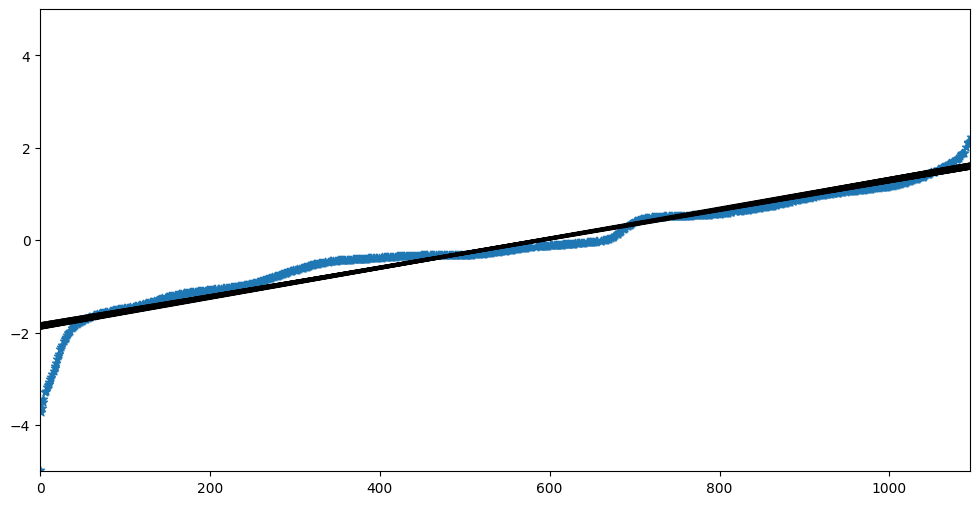

In [103]:
print_result(models_USA, points_USA, scaler_USA)

In [104]:
models_CAN, points_CAN, scaler_CAN = get_models(data[(data['location'] == 'Canada') & (data['date'] >= "2020-02-19")])

MSE test= 0.041376483232635854
r2_score test= 0.9609007608927489
E = [ 0.00332687 -2.05203187]
D = [[ 8.65391878e-10 -4.70952898e-07]
 [-4.70952898e-07  3.45908625e-04]]


Total coronavirus cases: 4608456.000000001
Pessimistic scenario: 4338.831730272621
Optimistic scenario: 0.0


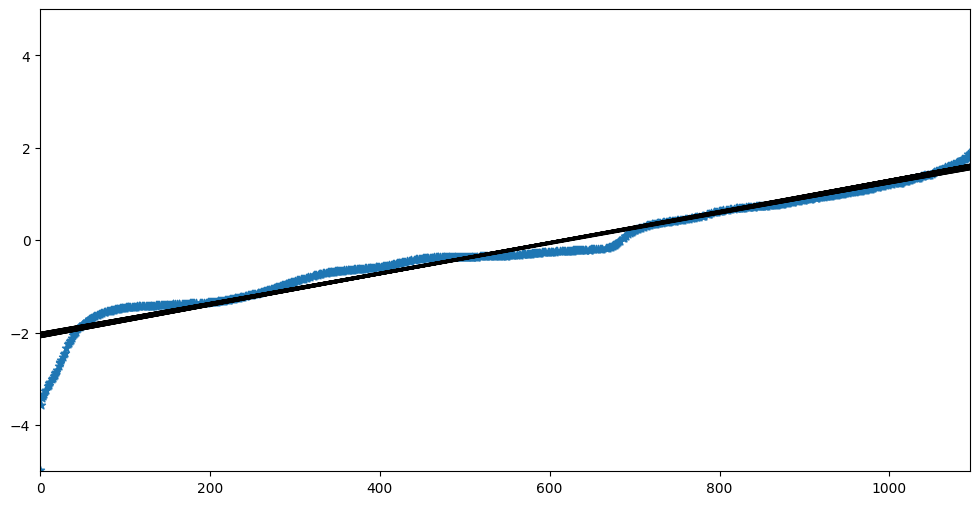

In [105]:
print_result(models_CAN, points_CAN, scaler_CAN)

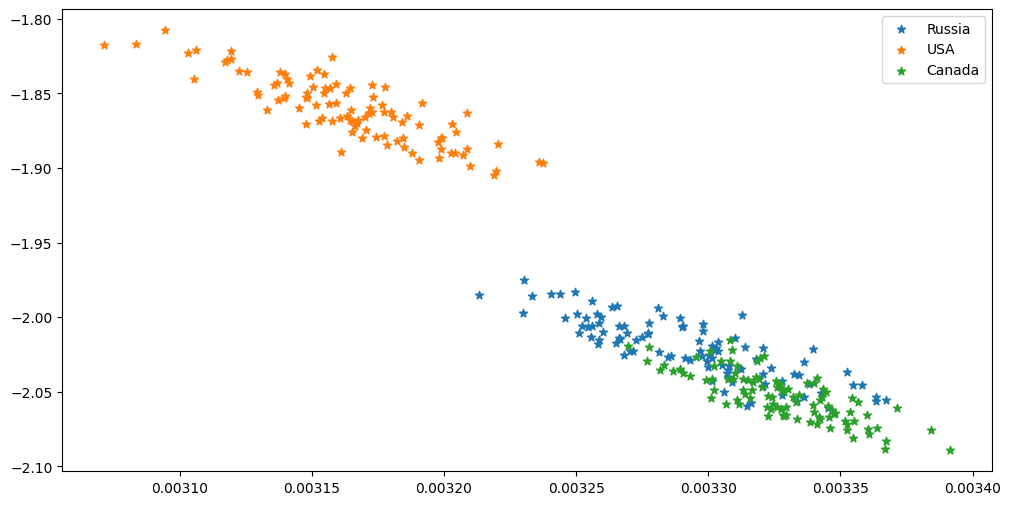

In [116]:
num = 100
plt.figure(figsize=(12, 6))
plt.scatter(models[:num, 0], models[:num, 1], marker='*', label="Russia")
plt.scatter(models_USA[:num, 0], models_USA[:num, 1], marker='*', label="USA")
plt.scatter(models_CAN[:num, 0], models_CAN[:num, 1], marker='*', label="Canada")
plt.legend()

Можно заметить, что США явно отделимо от России и Канады. Я считаю, что это произошло из-за того, что в США намного больше жителей. Но вот в случае Канады и России произошло наложение. То есть параметры в общем случае нельзя поделить на кластеры, хотя некоторые страны будут явно находиться поодаль.

# 5 Пункт

Главное, что я понял - с помощью линейной регрессии можно приближать даже интегральную зависимость при правильном преобразовании. Также было интересно наблюдать как изменяется приближение предсказательного распределения от количества моделей. Если взять порядка 100, то предсказания будут слишком смещенные, и мне даже казалось, что я где-то ошибся. 

Итого можно сказать, что коронавирус развивается достаточно быстро.

Я бы провел аналогию с другими болезнями на основании общих случаев и числа появления новых случаев. К чему это привело в прошлом. И на основании этого принял бы решение.